In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
from scipy.ndimage.interpolation import shift

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D, SimpleRNN, LSTM

In [17]:
#Loading data from PC- data:full original vector of solar irradiance 
data = pd.read_csv("solar_1h.csv", names=['irradiance'])
print(data.head())

   irradiance
0       0.000
1      90.475
2     183.280
3     435.890
4     594.660


In [18]:
data = data.values
print("Shape of data is ", data.shape)

Shape of data is  (4758, 1)


In [19]:
sigma = np.std(data)
mu = np.mean(data)
datanorm = (data-mu)/sigma

The shape of datamat is  (366, 13)


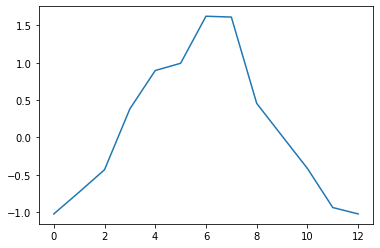

In [20]:
#Random shuffling to matrix across rows
datamat = data.reshape(366,-1)
print("The shape of datamat is ", datamat.shape)
datamat_norm = datanorm.reshape(366,-1)
plt.plot(datamat_norm[0])
datanorm = datamat_norm.reshape(-1,1)

In [21]:
#Function to Split into input ouput sets
def split_seq(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
    
        #Find end of seq
        end_ix = i+n_steps
        #Check if sequence passed
        if end_ix>len(seq)-1:
            break

        #Gather input and ouputs
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [64]:
n_steps = 4
trainval = 13*256 + 1

unk,y_recon = split_seq(datanorm, n_steps)
y_recon = y_recon[trainval :]

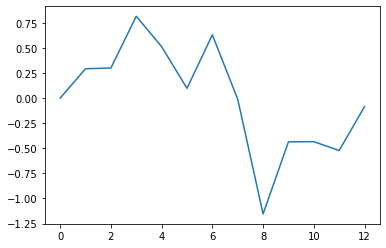

In [65]:
data_diff = datanorm-np.roll(datanorm,1)
plt.plot(data_diff[0:13])

In [66]:
#Training, Testing data split
trainX_diff = data_diff[0:trainval]
testX_diff = data_diff[trainval:]

In [67]:
n_steps = 4
n_features = 1

#Split into inputs, outputs for training data
Xdiff_train, Ydiff_train= split_seq(trainX_diff, n_steps)

Xdiff_train = Xdiff_train.reshape(Xdiff_train.shape[0],Xdiff_train.shape[1], n_features)

#Split into input and outputs for test data
Xdiff_test, Ydiff_test = split_seq(testX_diff, n_steps)

Xdiff_test = Xdiff_test.reshape(Xdiff_test.shape[0], Xdiff_test.shape[1], n_features)

In [69]:
#Define Model
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
# model.add(LSTM(32, activation='tanh', input_shape=(n_steps, n_features), dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
average_pooling1d_6 (Average (None, 1, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
____________________________________________________

In [70]:
#Fit model to difference transformed model
hist = model.fit(Xdiff_train, Ydiff_train, epochs=30, batch_size=32, validation_split=0.15, verbose=1, shuffle=False)

Train on 2826 samples, validate on 499 samples
Epoch 1/30
2826/2826 [==============================] - 2s 538us/sample - loss: 0.4357 - val_loss: 0.4118
Epoch 2/30
2826/2826 [==============================] - 0s 172us/sample - loss: 0.3770 - val_loss: 0.3833
Epoch 3/30
2826/2826 [==============================] - 1s 178us/sample - loss: 0.3585 - val_loss: 0.3686
Epoch 4/30
2826/2826 [==============================] - 1s 177us/sample - loss: 0.3513 - val_loss: 0.3613
Epoch 5/30
2826/2826 [==============================] - 0s 172us/sample - loss: 0.3474 - val_loss: 0.3582
Epoch 6/30
2826/2826 [==============================] - 0s 171us/sample - loss: 0.3447 - val_loss: 0.3550
Epoch 7/30
2826/2826 [==============================] - 1s 179us/sample - loss: 0.3425 - val_loss: 0.3528
Epoch 8/30
2826/2826 [==============================] - 0s 172us/sample - loss: 0.3407 - val_loss: 0.3509
Epoch 9/30
2826/2826 [==============================] - 0s 169us/sample - loss: 0.3389 - val_loss: 0.3488

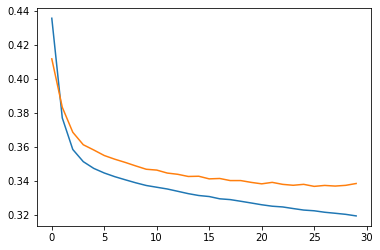

In [71]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='Cross validation')

In [72]:
#Predicting difference transformed data using NN model
yhat_difftest = model.predict(Xdiff_test, verbose=0)

In [73]:
ypred = (yhat_difftest + y_recon)*sigma +mu
yact = (Ydiff_test + y_recon)*sigma +mu

In [74]:
RMSE = np.sqrt(sum((ypred-yact)**2)/len(ypred))
print(f"RMSE is {RMSE}", )

RMSE is [182.98055231]
